In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn import svm
from empath import Empath
import itertools
import pickle
import spacy

from dataset_prep import dataset

In [2]:
filename = dataset()
data = pd.read_csv(filename)

data.loc[data['Label']== 0, 'Label'] = 'REAL'
data.loc[data['Label']== 1, 'Label'] = 'FAKE'

data.head()

,Headline,Body,Label
0,U.S. ends temporary protected status for Sudan...,WASHINGTON (Reuters) - The United States is en...,FAKE
1,Confident Trump says could 'shoot somebody' an...,"PELLA, Iowa /ANKENY, Iowa (Reuters) - U.S. Rep...",FAKE
2,Iran says no need to increase missile range as...,LONDON (Reuters) - Iran has no need to increas...,FAKE
3,Anti-Defamation League LITERALLY Schools Sean...,After White House Press Secretary Sean Spicer ...,REAL
4,EU must be part of U.S. Middle East peace push...,TALLINN (Reuters) - Israelis and Palestinians ...,FAKE


In [3]:
data['Label'].value_counts()

REAL    23481
FAKE    21417
Name: Label, dtype: int64

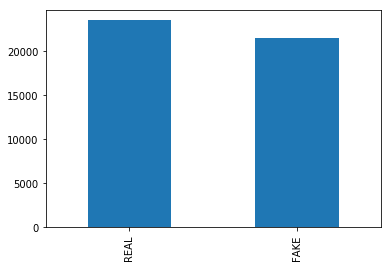

In [4]:
data['Label'].value_counts().plot(kind = 'bar')

## Data Cleaning

In [5]:
data['Text'] = data['Headline'].map(str) + data['Body']

#Drop Duplicates
data.drop_duplicates(subset='Text', inplace=True)

#Convert all to lower case
data['Text'] = data['Text'].str.lower()

#Remove all punctuations
data['Text'] = data['Text'].str.replace('[^\w\s]',' ')

#Remove all digits
data['Text'] = data['Text'].str.replace('[^A-Za-z]',' ')

#Double spaces removed
data['Text'] = data['Text'].str.replace('  ',' ')

y_data = data.Label
y_data = y_data.astype('str')

X_train, X_test, y_train, y_test = train_test_split(data['Text'], y_data, test_size=0.2)

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(31284,) (31284,)
(7821,) (7821,)


In [7]:
X_test[:10]

24324    playing politics here s why a judge will unsea...
37736     chicago police dept points out two huge flaws...
26572    epa chief visits indiana waste site amid propo...
17572     trump doubles down via the law moves to prote...
40855     watch fox news host vies for dumbest on netwo...
21922    the trump presidency on feb   at   p m est reu...
33423     elijah cummings called trump out to his face ...
38755    mccain says time for republicans democrats to ...
34709    gbagbo allies behind attacks in ivory coast in...
12311    ouch   minimum wage activist interviewed by ca...
Name: Text, dtype: object

## Vectorization

In [8]:
#Tf-idf Bigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))

TF_IDF_train1 = Tfidf_vectorizer.fit_transform(X_train.astype('str'))
TF_IDF_test1 = Tfidf_vectorizer.transform(X_test.astype('str'))

pickle.dump(TF_IDF_train1, open('TF_IDF_train1.pickle', 'wb'))
pickle.dump(TF_IDF_test1, open('TF_IDF_test1.pickle', 'wb'))

In [9]:
Tfidf_vectorizer.get_feature_names()[-10:]

['zztaine feminit',
 'zztw https',
 'zzuml hkoc',
 'zzywyr sean',
 'zzz ek',
 'zzzzaaaacccchhh april',
 'zzzzaaaacccchhh january',
 'zzzzaaaacccchhh march',
 'zzzzzzzz boring',
 'zzzzzzzzzzzzz new']

In [10]:
# Create a Confusion-Matrix
def generate_confusion_matrix(matrix, classes, normalize=False):
    
    plt.imshow(matrix, interpolation='nearest', cmap = plt.cm.Blues)
    plt.title('Confusion-Matrix')
    plt.colorbar()
    
    labels = np.arange(len(classes))
    plt.xticks(labels, classes, rotation=90)
    plt.yticks(labels, classes)
    
    if normalize:
        matrix = matrix.astype('float')/matrix.sum(axis=0)[:, np.newaxis]
        plt.title('Normalized Confusion-Matrix')
    
    thresh = matrix.max()/2
    
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Multinomial Naive Bayes

In [11]:
classifier = MultinomialNB()
classifier.fit(TF_IDF_train1, y_train)

pickle.dump(classifier, open('TF_IDF_NB', 'wb'))

pred = classifier.predict(TF_IDF_test1)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.950


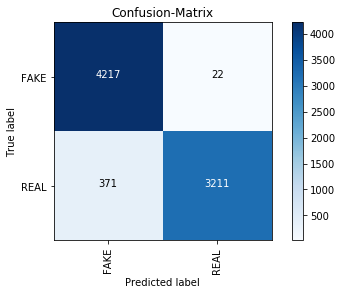

In [12]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

### Logistic Regression Classifier

In [13]:
classifier = LogisticRegression()
classifier.fit(TF_IDF_train1, y_train)

pickle.dump(classifier, open('TF_IDF_LR', 'wb'))

pred = classifier.predict(TF_IDF_test1)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Logistic regression classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with Logistic regression classifier:   0.977


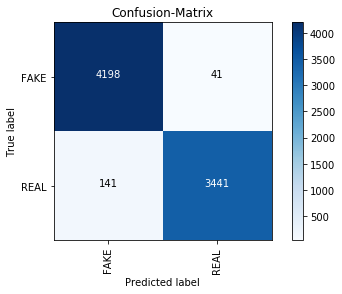

In [14]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

### Random Forest Classifier

In [15]:
classifier = RandomForestClassifier()
classifier.fit(TF_IDF_train1, y_train)

pickle.dump(classifier, open('TF_IDF_RF', 'wb'))

pred = classifier.predict(TF_IDF_test1)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Random Forest Classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with Random Forest Classifier:   0.943


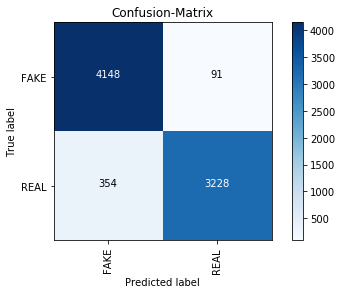

In [16]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

## Adding POS Tags in the dataset

In [17]:
import en_core_web_sm
nlp = en_core_web_sm.load()
x = []

data["Text"] = data["Headline"].map(str) + data["Body"]
for text in data['Text']:
    text_new = []
    doc = nlp(text)
    for token in doc:
        text_new.append(token.pos_)
    txt = ' '.join(text_new)
    x.append(txt)

data['Text_pos'] = x
data.to_pickle('newdata.pkl')

In [18]:
y_data = data.Label
y_data = y_data.astype('str')

X_train, X_test, y_train, y_test = train_test_split(data['Text_pos'], y_data, test_size=0.2)
X_train[:10]

23542    PROPN PART PROPN PROPN VERB PROPN PROPN ADP PR...
14318    ADJ NOUN VERB PROPN NOUN PUNCT PUNCT PUNCT PRO...
41917    SPACE PROPN PROPN VERB PROPN ADP PROPN PUNCT C...
19974    PROPN PROPN VERB PRON VERB SYM NUM NUM ADP NOU...
31720    ADJ ADJ NOUN VERB PROPN NOUN ADP VERB NOUN ADP...
6403     PROPN NOUN NOUN VERB NOUN ADP NOUN PART VERB N...
89       SPACE PUNCT ADJ PUNCT PROPN PROPN PART PROPN P...
23641    PROPN PROPN NOUN VERB ADV SCONJ PROPN PART ADJ...
9607     PROPN PART NOUN NOUN VERB ADV VERB PROPN PART ...
16219    PROPN VERB PART VERB PUNCT DET NOUN ADV PUNCT ...
Name: Text_pos, dtype: object

In [19]:
#Tf-idf Bigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))

TF_IDF_train2 = Tfidf_vectorizer.fit_transform(X_train.astype('str'))
TF_IDF_test2 = Tfidf_vectorizer.transform(X_test.astype('str'))

pickle.dump(TF_IDF_train2, open('TF_IDF_train2.pickle', 'wb'))
pickle.dump(TF_IDF_test2, open('TF_IDF_test2.pickle', 'wb'))

In [20]:
Tfidf_vectorizer.get_feature_names()[-10:]

['verb intj',
 'verb noun',
 'verb num',
 'verb pron',
 'verb propn',
 'verb punct',
 'verb sconj',
 'verb space',
 'verb sym',
 'verb verb']

In [21]:
classifier = MultinomialNB()
classifier.fit(TF_IDF_train2, y_train)

pickle.dump(classifier, open('POS_NB', 'wb'))

pred = classifier.predict(TF_IDF_test2)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.878


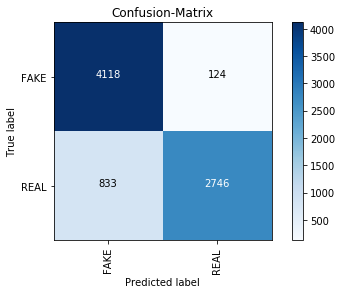

In [22]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

In [23]:
classifier = LogisticRegression()
classifier.fit(TF_IDF_train2, y_train)

pickle.dump(classifier, open('POS_LR', 'wb'))

pred = classifier.predict(TF_IDF_test2)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Logistic regression classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with Logistic regression classifier:   0.955


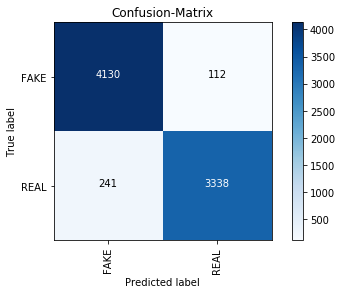

In [24]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

In [25]:
classifier = RandomForestClassifier()
classifier.fit(TF_IDF_train2, y_train)

pickle.dump(classifier, open('POS_RF', 'wb'))

pred = classifier.predict(TF_IDF_test2)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Random Forest Classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with Random Forest Classifier:   0.945


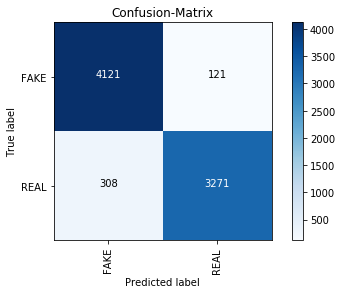

In [26]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

## Using Sentiments to classify Fake News

In [27]:
#Getting the score of semantic categories generated by Empath of each article and generating a tfidf vector.

In [28]:
sentiment = Empath()
semantic = []
count = 0

data['Text'] = data['Headline'].map(str) + data['Body']

for article in data['Text']:
    
    if article == '':
        continue
    
    count += 1
    res = sentiment.analyze(article, normalize=False)
    arr = []
    for key, value in res.items():
        arr.append(value)
    
    arr = np.array(arr)
    semantic.append(arr)

data['Semantics'] = semantic

In [29]:
semantic[0]

array([1., 0., 0., 2., 0., 6., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 3., 0., 0., 0., 1., 5., 0., 0., 0., 0., 5.,
       0., 0., 0., 0., 0., 0., 0., 1., 7., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0.])

In [30]:
categories = []
a = sentiment.analyze("")
for key, value in a.items():
    categories.append(key)
categories

['business',
 'dance',
 'phone',
 'government',
 'poor',
 'messaging',
 'religion',
 'monster',
 'hipster',
 'money',
 'play',
 'ship',
 'domestic_work',
 'crime',
 'school',
 'trust',
 'affection',
 'valuable',
 'weapon',
 'medical_emergency',
 'positive_emotion',
 'night',
 'worship',
 'military',
 'horror',
 'deception',
 'order',
 'payment',
 'help',
 'injury',
 'masculine',
 'hearing',
 'family',
 'war',
 'violence',
 'science',
 'animal',
 'fun',
 'superhero',
 'fashion',
 'beauty',
 'negotiate',
 'social_media',
 'cleaning',
 'anonymity',
 'sports',
 'hate',
 'leader',
 'disgust',
 'cooking',
 'journalism',
 'office',
 'internet',
 'programming',
 'swimming',
 'speaking',
 'warmth',
 'sadness',
 'dominant_heirarchical',
 'car',
 'divine',
 'listen',
 'childish',
 'furniture',
 'competing',
 'work',
 'plant',
 'exotic',
 'death',
 'love',
 'traveling',
 'feminine',
 'white_collar_job',
 'ugliness',
 'royalty',
 'sleep',
 'noise',
 'negative_emotion',
 'weather',
 'eating',
 'exer

In [31]:
len(categories)

194

In [32]:
sem = []

for i in range(data.shape[0]):
    
    a = []
    for j in range(len(semantic[0])):
        for k in range(int(semantic[i][j])):     ## each semantic of every word in every article
            a.append(categories[j])
        
    b = " ".join(a)
    sem.append(b)

data['Sentiments'] = sem
data.to_pickle('Sentiments.pkl')

In [33]:
sem[0]

'business government government messaging messaging messaging messaging messaging messaging weapon weapon military military military payment help help help help help war war war war war negotiate social_media social_media social_media social_media social_media social_media social_media cooking speaking speaking work death traveling traveling royalty politics children banking wealthy giving air_travel independence terrorism dispute dispute dispute dispute vacation law wedding philosophy philosophy college power urban meeting fight fight fight'

In [48]:
df = pd.read_pickle('Sentiments.pkl')
print(df.columns)
print(df.shape)

Index(['Headline', 'Body', 'Label', 'Text', 'Text_pos', 'Semantics',
       'Sentiments'],
      dtype='object')
(39105, 7)


In [49]:
y_data = df.Label
y_data = y_data.astype('str')
X_train, X_test, y_train, y_test = train_test_split(df['Semantics'], y_data, test_size=0.33)

In [50]:
X_train

15559    [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8121     [2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
24094    [3.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...
40709    [4.0, 0.0, 2.0, 6.0, 0.0, 2.0, 5.0, 0.0, 2.0, ...
33085    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8094     [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
20277    [4.0, 0.0, 1.0, 5.0, 0.0, 3.0, 0.0, 0.0, 0.0, ...
14091    [0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
12718    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
15832    [4.0, 1.0, 0.0, 7.0, 0.0, 5.0, 0.0, 0.0, 0.0, ...
29047    [3.0, 0.0, 1.0, 7.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...
9648     [5.0, 1.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
437      [1.0, 0.0, 0.0, 4.0, 0.0, 0.0, 3.0, 0.0, 1.0, ...
25889    [2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...
11692    [5.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 3.0, ...
24601    [5.0, 0.0, 1.0, 12.0, 4.0, 1.0, 0.0, 0.0, 0.0,...
22117    [5.0, 0.0, 0.0, 8.0, 2.0, 1.0, 0.0, 0.0, 0.0, .

In [51]:
#Tf-idf Unigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1))

TF_IDF_train3 = Tfidf_vectorizer.fit_transform(X_train.astype('str'))
TF_IDF_test3 = Tfidf_vectorizer.transform(X_test.astype('str'))

pickle.dump(TF_IDF_train3, open('TF_IDF_train3.pickle', 'wb'))
pickle.dump(TF_IDF_test3, open('TF_IDF_test3.pickle', 'wb'))

In [52]:
Tfidf_vectorizer.get_feature_names()[-10:]

['80', '81', '82', '83', '84', '87', '88', '90', '92', '94']

In [59]:
# NO NEED TO USE VECTORIZATION ON SENTIMENTS AS THEY HAVE ALREADY BEEN VECTORIZED IN WORD EMBEDDINGS OF SEMANTICS

classifier = MultinomialNB()
classifier.fit(X_train.to_list(), y_train)

pickle.dump(classifier, open('SENT_NB', 'wb'))

pred = classifier.predict(X_test.to_list())
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.781


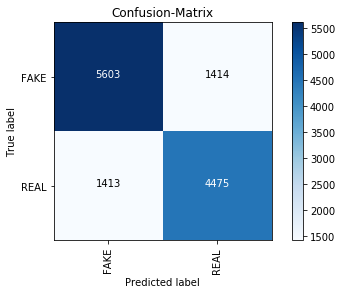

In [60]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

In [61]:
classifier = LogisticRegression()
classifier.fit(X_train.to_list(), y_train)

pickle.dump(classifier, open('SENT_LR', 'wb'))

pred = classifier.predict(X_test.to_list())
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Logistic regression classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with Logistic regression classifier:   0.824


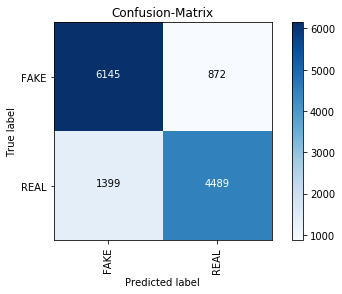

In [62]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

In [63]:
classifier = RandomForestClassifier()
classifier.fit(X_train.to_list(), y_train)

pickle.dump(classifier, open('SENT_RF', 'wb'))

pred = classifier.predict(X_test.to_list())
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Random Forest Classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with Random Forest Classifier:   0.811


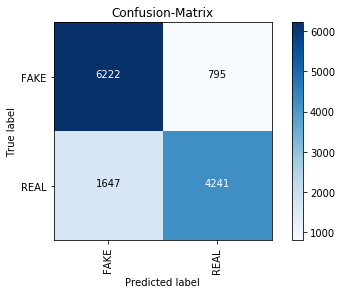

In [64]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

## Combining these 3 parameters to build a final model

In [104]:
data = pd.read_pickle('Sentiments.pkl')
print(data.columns)
print(data.shape)

Index(['Headline', 'Body', 'Label', 'Text', 'Text_pos', 'Semantics',
       'Sentiments'],
      dtype='object')
(39105, 7)


In [105]:
y_data = data.Label
X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.33)

In [106]:
X_train_text = X_train['Text']
X_test_text = X_test['Text']

X_train_text_pos = X_train['Text_pos']
X_test_text_pos = X_test['Text_pos']

X_train_semantics = X_train['Semantics']
X_test_semantics = X_test['Semantics']

In [107]:
#Tf-idf Bigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))

TF_IDF_train1 = Tfidf_vectorizer.fit_transform(X_train_text.astype('str'))
TF_IDF_test1 = Tfidf_vectorizer.transform(X_test_text.astype('str'))

pickle.dump(TF_IDF_train1, open('TF_IDF_train1.pickle', 'wb'))
pickle.dump(TF_IDF_test1, open('TF_IDF_test1.pickle', 'wb'))

In [108]:
#Tf-idf Bigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2,2))

TF_IDF_train2 = Tfidf_vectorizer.fit_transform(X_train_text_pos.astype('str'))
TF_IDF_test2 = Tfidf_vectorizer.transform(X_test_text_pos.astype('str'))

pickle.dump(TF_IDF_train2, open('TF_IDF_train2.pickle', 'wb'))
pickle.dump(TF_IDF_test2, open('TF_IDF_test2.pickle', 'wb'))

In [109]:
#Tf-idf Unigrams
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1))

TF_IDF_train3 = Tfidf_vectorizer.fit_transform(X_train_semantics.astype('str'))
TF_IDF_test3 = Tfidf_vectorizer.transform(X_test_semantics.astype('str'))

pickle.dump(TF_IDF_train3, open('TF_IDF_train3.pickle', 'wb'))
pickle.dump(TF_IDF_test3, open('TF_IDF_test3.pickle', 'wb'))

In [110]:
# The three vector features

train1 = TF_IDF_train1
test1 = TF_IDF_test1

train2 = TF_IDF_train2
test2 = TF_IDF_test2

train3 = TF_IDF_train3
test3 = TF_IDF_test3

In [111]:
#Giving weights to each of the 3 feature vectors generated

big_w = 0.35
synt_w = 0.5
sem_w = 0.15
big_w *= 3
synt_w *= 3
sem_w *= 3

TF_IDF_train1 = big_w*train1
TF_IDF_test1 = big_w*test1

TF_IDF_train2 = synt_w*train2
TF_IDF_test2 = synt_w*test2

TF_IDF_train3 = sem_w*train3
TF_IDF_test3 = sem_w*test3

In [112]:
import scipy.sparse as sp

diff_n_rows = TF_IDF_train2.shape[0] - TF_IDF_train1.shape[0]

Xb_new = sp.vstack((TF_IDF_train1, sp.csr_matrix((diff_n_rows, TF_IDF_train1.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

c = sp.hstack((TF_IDF_train2, Xb_new))

diff_n_rows = c.shape[0] - TF_IDF_train3.shape[0]

Xb_new = sp.vstack((TF_IDF_train3, sp.csr_matrix((diff_n_rows, TF_IDF_train3.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

X = sp.hstack((c, Xb_new))
X

dif_n_rows = TF_IDF_test2.shape[0] - TF_IDF_test1.shape[0]

Xb_ne = sp.vstack((TF_IDF_test1, sp.csr_matrix((dif_n_rows, TF_IDF_test1.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

d = sp.hstack((TF_IDF_test2, Xb_ne))

dif_n_rows = d.shape[0] - TF_IDF_test3.shape[0]

Xb_ne = sp.vstack((TF_IDF_test3, sp.csr_matrix((dif_n_rows, TF_IDF_test3.shape[1])))) 
#where diff_n_rows is the difference of the number of rows between Xa and Xb

Y = sp.hstack((d, Xb_ne))

In [113]:
classifier = MultinomialNB()
classifier.fit(X, y_train)

pickle.dump(classifier, open('Bi_POS_SENT_NB', 'wb'))

pred = classifier.predict(Y)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

Accuracy with Multinomial Naive Bayes:   0.913


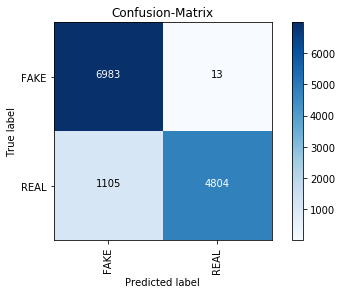

In [114]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

In [115]:
classifier = LogisticRegression()
classifier.fit(X, y_train)

pickle.dump(classifier, open('Bi_POS_SENT_LR', 'wb'))

pred = classifier.predict(Y)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Logistic regression classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with Logistic regression classifier:   0.968


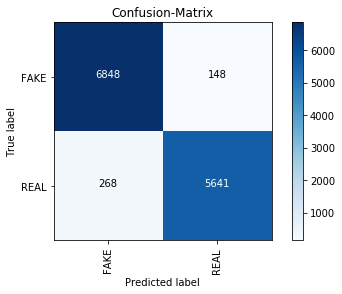

In [116]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])

In [117]:
classifier = RandomForestClassifier()
classifier.fit(X, y_train)

pickle.dump(classifier, open('Bi_POS_SENT_RF', 'wb'))

pred = classifier.predict(Y)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy with Random Forest Classifier:   %0.3f" % score)

/home/vinayak/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy with Random Forest Classifier:   0.915


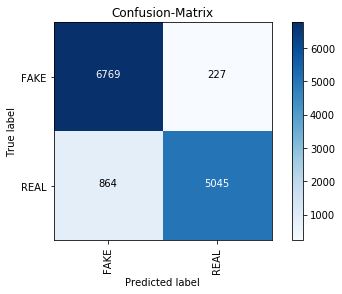

In [118]:
matrix = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
generate_confusion_matrix(matrix, classes=['FAKE', 'REAL'])